In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from simple_tritium_transport_model import (
    Model,
    ureg,
    quantity_to_activity,
    plot_bars,
    plot_integrated_top_release,
    plot_integrated_wall_release,
    plot_top_release,
    plot_wall_release,
    plot_sample_activity_top,
    plot_irradiation,
    plot_salt_inventory,
)
from baby_run_3 import *

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
from baby_run_3 import baby_model
baby_model.run(6 * ureg.day)


/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/base.py:22: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)


/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:448: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:452: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)
/home/remidm/.local/lib/python3.10/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(
/home/remidm/.local/lib/python3.10/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child1), but could not find a label for it.
  warnings.warn(


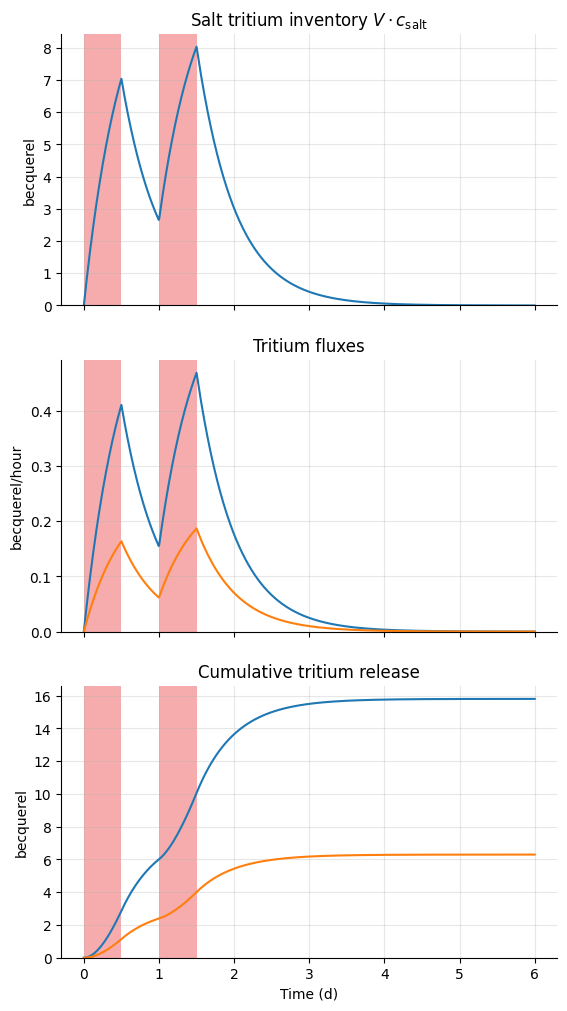

In [3]:
time = baby_model.times.to(ureg.day)

fig, (ax_inv, ax_fluxes, ax_cumul) = plt.subplots(3, 1, sharex=True, figsize=(6.4, 12))

plt.sca(ax_inv)
plt.title("Salt tritium inventory $V \cdot c_\mathrm{salt}$")
plot_salt_inventory(baby_model)

plt.sca(ax_fluxes)
plt.title("Tritium fluxes")

plot_top_release(baby_model)
plot_wall_release(baby_model)

plt.sca(ax_cumul)
plt.title("Cumulative tritium release")
plot_integrated_top_release(baby_model)
plot_integrated_wall_release(baby_model)

plt.xlabel(f"Time ({time.units:~P})")

for ax in [ax_inv, ax_fluxes, ax_cumul]:
    ax.set_ylim(bottom=0)
    ax.grid(alpha=0.3)
    labelLines(ax.get_lines(), zorder=2.5)
    plt.sca(ax)
    plot_irradiation(baby_model, facecolor="#EF5B5B", alpha=0.5)

plt.savefig("baby_run_3/basic_model_results.svg")
plt.show()


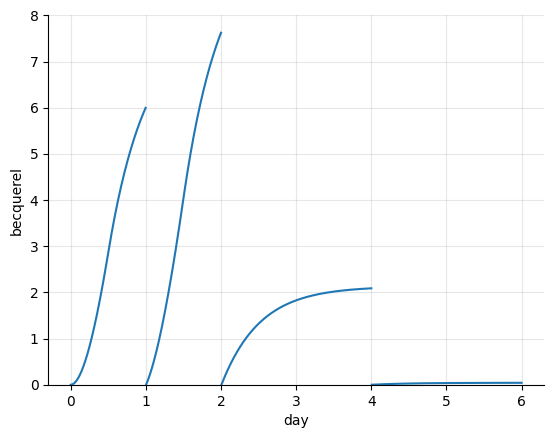

In [4]:
plt.figure()
plot_sample_activity_top(baby_model, replacement_times=replacement_times)
plt.grid(alpha=0.3)
plt.ylim(bottom=0*ureg.Bq)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_3/results_no_exp.svg")


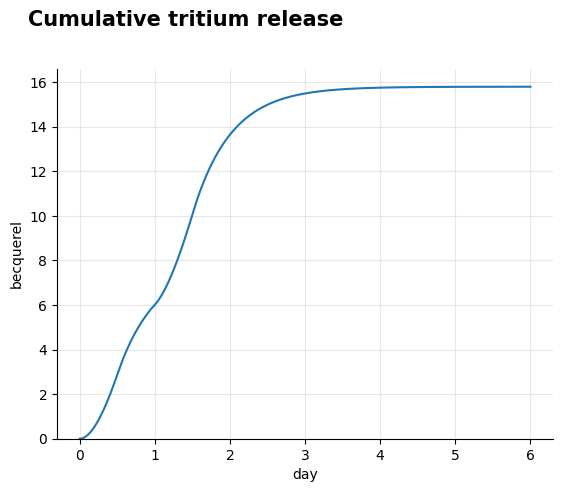

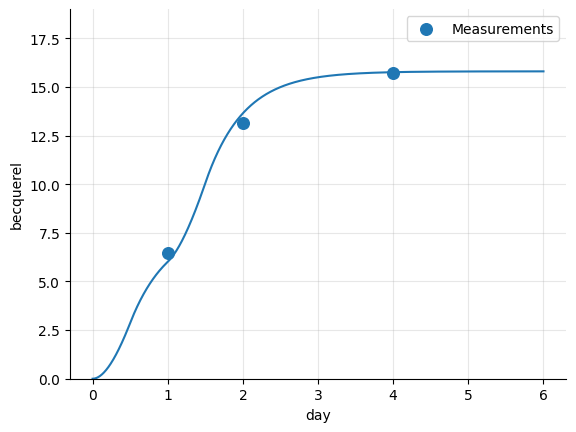

In [5]:
plot_integrated_top_release(baby_model)
plt.ylim(bottom=0*ureg.Bq)
plt.grid(alpha=0.3)
plt.gcf().text(0.08, 0.97, "Cumulative tritium release", weight="bold", fontsize=15)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_3/cumulative_tritium_release_no_exp.svg")

plt.figure()
plot_integrated_top_release(baby_model)
s = plt.scatter(
    replacement_times,
    cumulative_release,
    s=70,
    label="Measurements",
)
plt.grid(alpha=0.3)
plt.ylim(bottom=0*ureg.Bq)
plt.legend(handles=[s])
plt.gca().set_axisbelow(True)
plt.ylim(top=19 * ureg.Bq)
plt.savefig("baby_run_3/cumulative_tritium_release.svg")


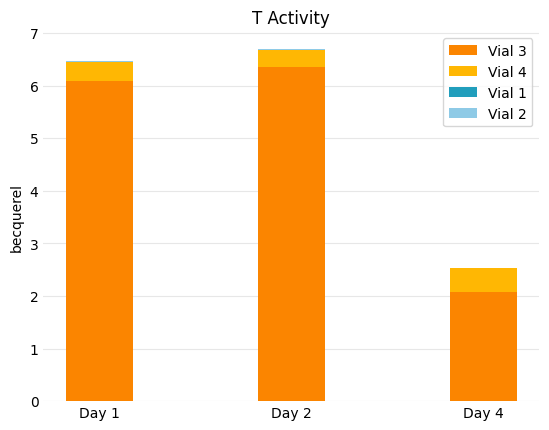

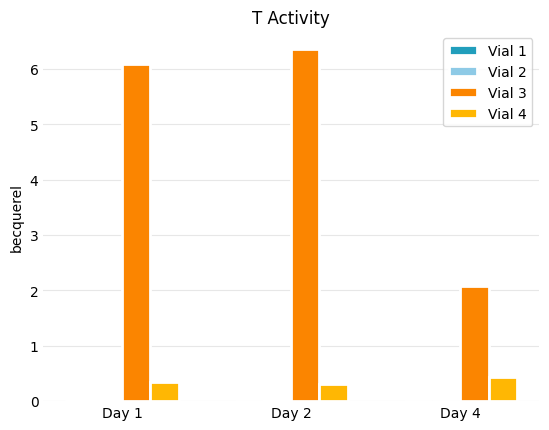

In [6]:
plt.figure()

for stacked in [True, False]:
    index = plot_bars(measurements_after_background_sub, stacked=stacked)
    plt.xticks(index, ["Day 1", "Day 2", "Day 4"])
    plt.title("T Activity")
    plt.legend()
    plt.gca().spines[["right", "bottom", "top", "left"]].set_visible(False)
    plt.grid(True, axis="y", alpha=0.3)
    plt.gca().tick_params(axis="both", which="both", length=0)
    if stacked:
        plt.savefig("baby_run_3/LSC results_stacked.svg")
    else:
        plt.savefig("baby_run_3/LSC results.svg")
    plt.gca().set_axisbelow(True)
    plt.show()


/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:448: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:452: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)


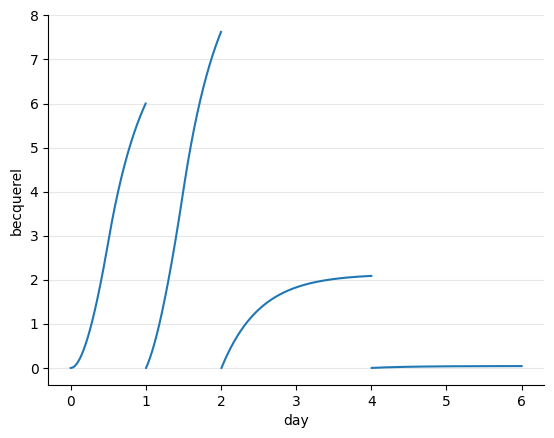

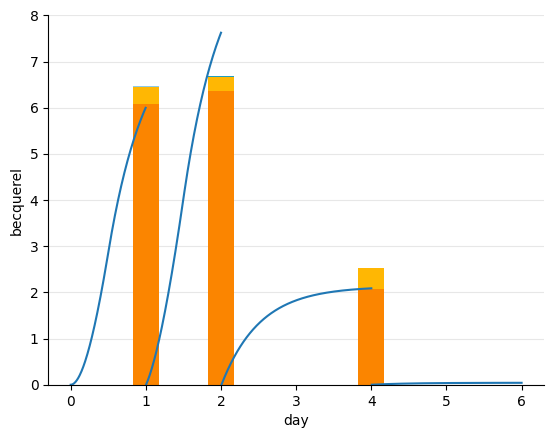

In [7]:
plt.figure()
plot_sample_activity_top(baby_model, replacement_times=replacement_times)
plt.grid(False)
plt.grid(True, axis="y", alpha=0.3)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_3/sample_activity_no_exp.svg")

plt.figure()
plot_bars(measurements_after_background_sub, index=[1 * ureg.day, 2 * ureg.day, 4 * ureg.day])
plot_sample_activity_top(baby_model, replacement_times=replacement_times)
plt.grid(False)
plt.grid(True, axis="y", alpha=0.3)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_3/sample_activity.svg")


In [8]:
m = measurements_after_background_sub
efficiency_1 = m[1][3] / (m[1][3] + m[1][4])
efficiency_2 = m[2][3] / (m[2][3] + m[2][4])

average_efficiency = np.mean([efficiency_1, efficiency_2])

nb_vials = 2
total_eff = 1 - (1 - average_efficiency) ** nb_vials
print(f"Average efficiency per vial {average_efficiency:.2%}")
print(f"Total efficiency ({nb_vials} vials): {total_eff:.2%}")


Average efficiency per vial 94.90%
Total efficiency (2 vials): 99.74%


/home/remidm/.local/lib/python3.10/site-packages/numpy/core/_methods.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  arr = asanyarray(a)


/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/base.py:22: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)


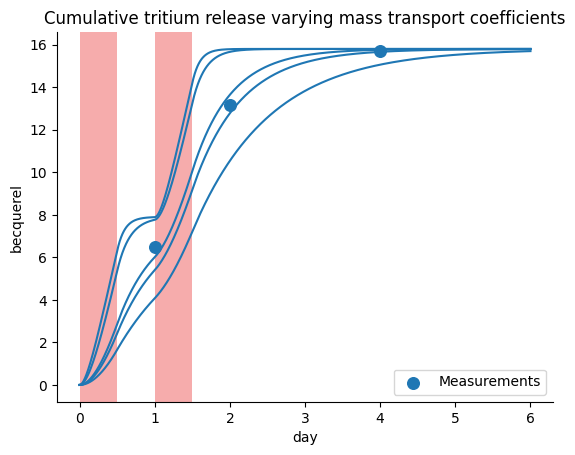

In [9]:
for i, mass_transport_coeff_factor2 in enumerate([0.5, 0.8, 1, 3, 5]):
    new_baby_model = Model(
        radius=baby_radius,
        height=baby_height,
        TBR=baby_model.TBR,
    )

    new_baby_model.k_top *= mass_transport_coeff_factor * mass_transport_coeff_factor2
    new_baby_model.k_wall *= mass_transport_coeff_factor * mass_transport_coeff_factor2

    new_baby_model.irradiations = baby_model.irradiations
    new_baby_model.neutron_rate = baby_model.neutron_rate
    new_baby_model.run(6 * ureg.day)
    if i == 0:
        plot_irradiation(new_baby_model, facecolor="#EF5B5B", alpha=0.5)
    plot_integrated_top_release(new_baby_model, color="tab:blue")
plt.title("Cumulative tritium release varying mass transport coefficients")
s = plt.scatter(
    replacement_times,
    cumulative_release,
    s=70,
    label="Measurements",
)
plt.legend(handles=[s])
